# Data Wrangling and Cleaning
This notebook investigates the raw and partially processed datasets. 

# Orders Dataset

## Cleaning

Cleaning steps are refactored into "belly_rubb_analysis/dataset.py". These include:
    - Enforcing correct datatypes found in "docs/datatypes/".
    - Dropping columns with more than 70% missing values.
    - Dropping duplicate rows.
    - Dropping columns with a constant value.

In [90]:
import os
import pandas as pd

# Data Visualization
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import missingno as msno

# Configuration info
%load_ext autoreload
%autoreload 1
%aimport belly_rubb_analysis.config
from belly_rubb_analysis.config import INTERIM_DATA_DIR, RAW_DATA_DIR, PROFILE_REPORTS_DIR, FIGURES_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
orders_df = pd.read_csv(INTERIM_DATA_DIR / 'orders-2023-12-22-2024-12-20.csv')

orders_df.head()

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
0,Uber Eats Delivery A97C3,2024-12-20,48.99,4.65,53.64,2024-12-20 13:25:00,Pickup,Completed,Postmates Delivery,A97C3-Olga G.,NaN,+1 312-766-6835,1,BEEF BACK RIBS (Full Rack),Regular,1 x Signature BBQ Glaze,48.99,48.99,53.64
1,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x No Cheddar, 1 x No Provolone, 1 x Signatur...",11.99,22.18,24.29
2,Uber Eats Delivery 86B6C,2024-12-19,40.12,3.81,43.93,2024-12-19 18:40:00,Pickup,Completed,Postmates Delivery,86B6C-Martin T.,NaN,+1 312-766-6835,1,CHICKEN WINGS,6 pcs,1 x Sweet&Spicy glaze (Pairs well w/ LemonPeep...,17.94,17.94,19.64
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
4,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,LOADED FRIES,Regular,"1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pe...",11.99,12.74,13.95


In [92]:
# Generate initial report of orders.csv

if not os.path.exists(PROFILE_REPORTS_DIR / 'orders-profile-report.html'):
    profile = ProfileReport(orders_df, title='Orders Profiling Report')
    profile.to_file('./../reports/profile-reports/orders-profile-report.html')

In [93]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order                     1413 non-null   object 
 1   Order Date                1414 non-null   object 
 2   Order Subtotal            1414 non-null   float64
 3   Order Tax Total           1414 non-null   float64
 4   Order Total               1414 non-null   float64
 5   Fulfillment Date          1414 non-null   object 
 6   Fulfillment Type          1414 non-null   object 
 7   Fulfillment Status        1414 non-null   object 
 8   Channels                  1414 non-null   object 
 9   Recipient Name            1414 non-null   object 
 10  Recipient Email           1073 non-null   object 
 11  Recipient Phone           1414 non-null   object 
 12  Item Quantity             1414 non-null   int64  
 13  Item Name                 1413 non-null   object 
 14  Item Var

## Missing Values

Although columns with more than 70% missing values were dropped, there are a few left with considerable missingness. These include:

    - `Recipient Email`: 23.8% missing
    - `Order`: 0.1% missing
    - `Item Name`: 0.1% missing
    - `Item Variation`: 0.1% missing
    - `Item Modifiers`: 40.5% missing

These will be investigated for any patterns.

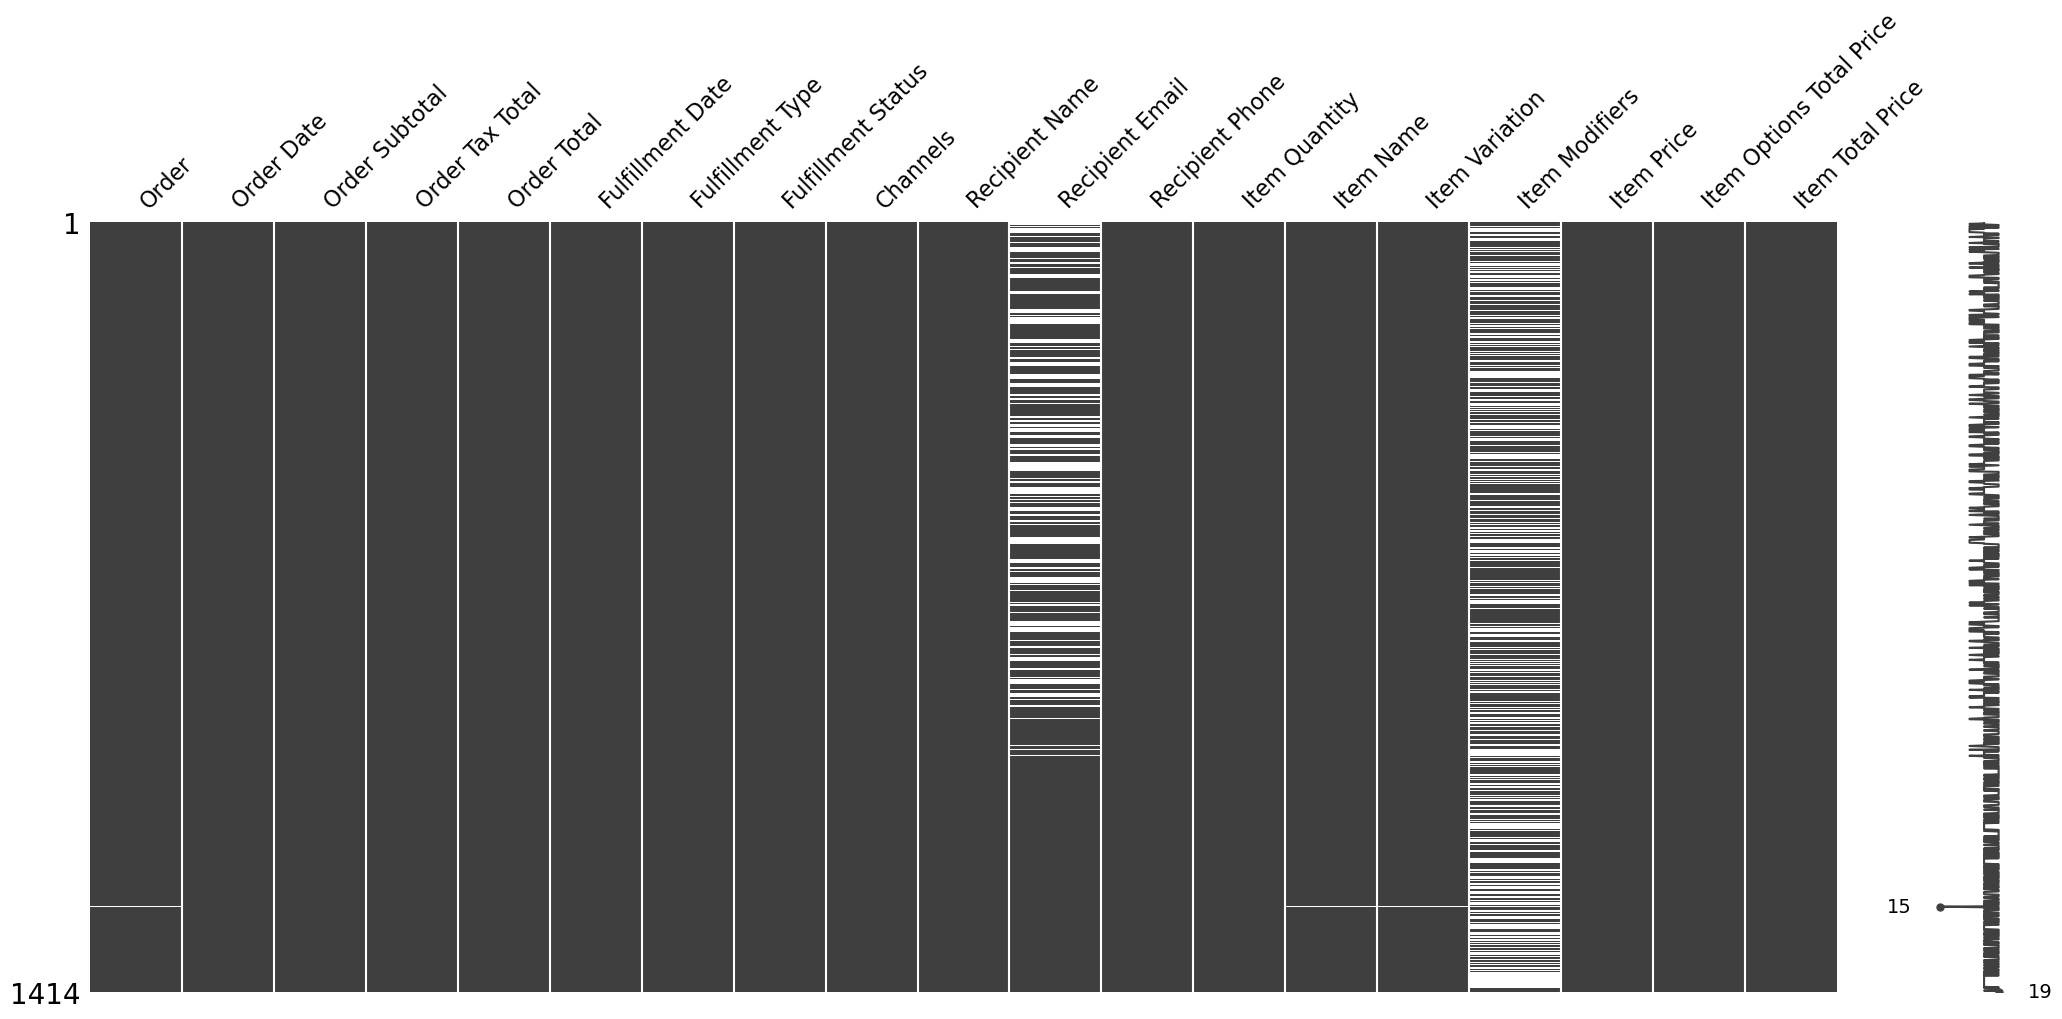

In [94]:
# Visualize missingness matrix

msno.matrix(orders_df)

plt.show()

### Order, Item Name, and Item Variation

There is one row which has missing values between Order, Item Name, Item Variation, and possibly Item Modifiers. We will investigate this row to understand the cause.

In [95]:
# Pull up single row with a missing value in Order

orders_df[orders_df['Order'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
1256,NaN,2024-03-07,450.0,42.75,512.75,2024-03-07 16:14:00,Other,Completed,BELLY RUBB | BBQ Catering | Barbecue To Go and...,Levon Safaryan,bidium@gmail.com,+1 818-822-5060,1,NaN,NaN,NaN,450.0,450.0,492.75


Looks like this row is missing information about the items ordered as well. This could have been an order for a family member or friend, catering event, or cash which was entered into the system later.

### Item Modifiers

This column is missing 40.5% of its values. This is most likely due to the fact that this is an optional field for customers to enter personalized modifications when ordering. Just to be sure we'll see if there's a pattern to this missingness.

In [96]:
# Investigate values in Item Modifiers

orders_df['Item Modifiers'].unique()

array(['1 x Signature BBQ Glaze',
       '1 x No Cheddar, 1 x No Provolone, 1 x Signature BBQ Sauce Drizzle, 1 x Sweet and Spicy BBQ Sauce Dip, 1 x Lemon Pepper, 1 x Add Pork Rib Meat (Of-The-Bone!)',
       '1 x Sweet&Spicy glaze (Pairs well w/ LemonPeeper seasoning), 1 x Zesty Lemon Pepper',
       nan, '1 x Blue Cheese Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Sweet&Spicy Glaze, 1 x Please, cut it!',
       '1 x Add gorgonzola! Make it special.',
       '1 x Please, cut it!, 1 x Signature BBQ Glaze',
       '1 x Signature BBQ Sauce Drizzle, 1 x Salt and Pepper',
       '1 x Lemon Pepper',
       '1 x Sprite ™, 1 x Mac & Cheese, 1 x Rosemary Pepper Fries, 1 x Sweet&Spicy Glaze, 1 x Boom-Boom Sauce DIp',
       '1 x Boom-Boom Sauce DIp, 1 x Sweet and Spicy BBQ Sauce Dip',
       '1 x Sweet and Spicy BBQ Sauce Dip, 1 x Pickled Jalapeño Peppers',
       '1 x Signature BBQ Glaze, 1 x Signature BBQ Sauce Dip',
       '1 x Rosemary Pepper',
       '1 x Salt&Pepper, 1 x Sweet&Spicy g

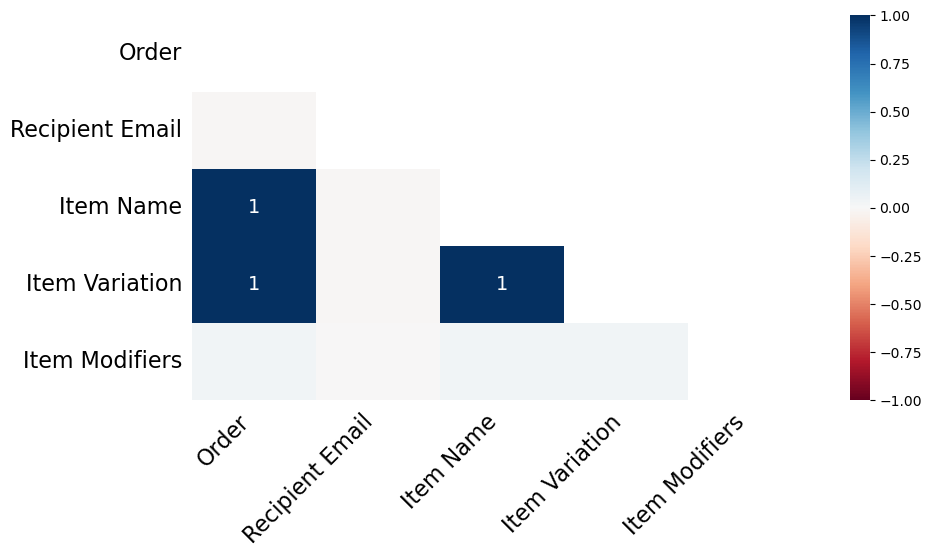

In [97]:
# Visualize missingness correlation

msno.heatmap(orders_df, figsize=(10,5))

plt.show()

The perfectly correlated features come from the single row which had all of those missing. Otherwise, there are no significant missingness correlations.

In [98]:
orders_df[orders_df['Item Modifiers'].isna()]

,Order,Order Date,Order Subtotal,Order Tax Total,Order Total,Fulfillment Date,Fulfillment Type,Fulfillment Status,Channels,Recipient Name,Recipient Email,Recipient Phone,Item Quantity,Item Name,Item Variation,Item Modifiers,Item Price,Item Options Total Price,Item Total Price
3,Uber Eats Delivery 1B73A,2024-12-19,32.19,3.06,35.25,2024-12-19 14:59:00,Pickup,Completed,Postmates Delivery,1B73A-Diana O.,NaN,+1 312-766-6835,1,CIABATTA STEAK SANDWICH,Regular,NaN,19.45,19.45,21.30
7,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,PINEAPPLE SLAW,Full,NaN,9.46,9.46,9.46
8,Postmates Delivery EAA45,2024-12-19,22.06,1.20,23.26,2024-12-19 11:26:00,Pickup,Completed,Postmates Delivery,EAA45-Anthony S.,NaN,+1 312-766-6835,1,ARTISAN MAC AND CHEESE,Full,NaN,12.60,12.60,13.80
11,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CRISPY CHICKEN SANDWICH,Regular,NaN,16.46,16.46,18.02
13,Uber Eats Delivery 8F819,2024-12-18,37.90,3.46,41.36,2024-12-18 13:58:00,Pickup,Completed,Postmates Delivery,8F819-Diana O.,NaN,+1 312-766-6835,1,CREAMY BLUE CHEESE DIP,Regular,NaN,1.45,1.45,1.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,DOORDASH,2024-01-05,31.97,2.28,34.25,2024-01-05 15:12:00,Pickup,Completed,DoorDash,Brandon K,point-of-sale-integration@doordash.com,8559731040,1,GET YOUR BABY BACK!,Half rack,NaN,23.99,23.99,25.70
1402,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,MAC&CHEESE,Side,NaN,4.99,4.99,5.46
1403,DOORDASH,2024-01-05,20.81,1.98,22.79,2024-01-05 13:49:00,Pickup,Completed,DoorDash,Timothy L,point-of-sale-integration@doordash.com,8559731040,1,CRINKLE FRIES,"Side, Rosemary pepper",NaN,4.99,4.99,5.47
1405,DOORDASH,2024-01-04,35.37,2.60,37.97,2024-01-04 17:31:00,Pickup,Completed,DoorDash,Benjamin B,point-of-sale-integration@doordash.com,8559731040,1,GRILLED SWEET CORN,Regular,NaN,2.99,2.99,3.21


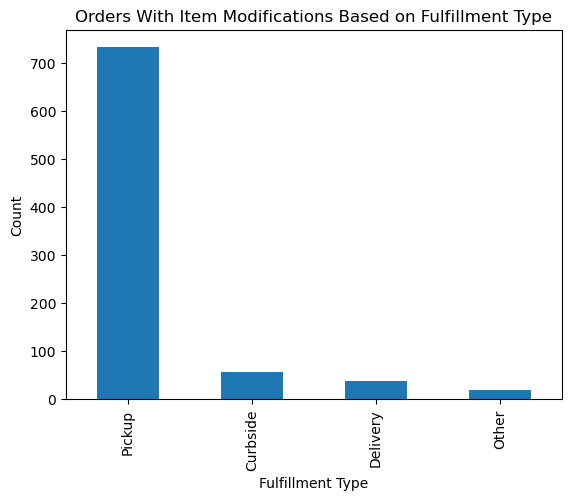

In [99]:
# Visualize relationship between item modifications and fulfillment type

orders_df.groupby(by='Fulfillment Type')['Item Modifiers'].count().sort_values(ascending=False).plot(kind='bar')

plt.title('Orders With Item Modifications Based on Fulfillment Type')
plt.ylabel('Count')
plt.xlabel('Fulfillment Type')

plt.savefig(FIGURES_DIR / 'bar_fulfillment_type_item_modifiers_count.png', bbox_inches='tight')
plt.show()

### Recipient Email

This column is missing 23.8% of its values, so we'll investigate this as well. Most likely this is also a customer preference.

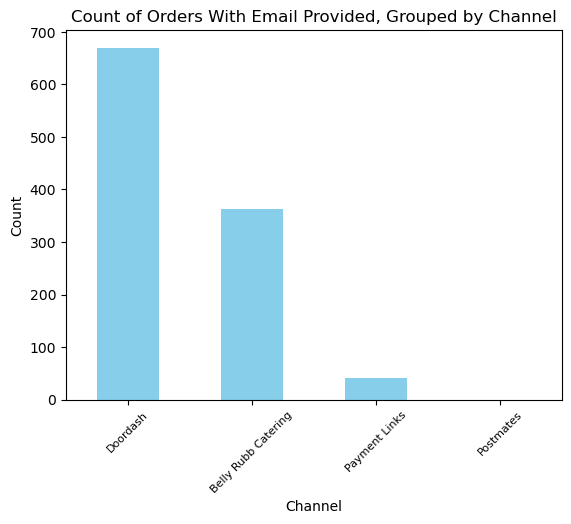

In [104]:
# Visualize count of whose emails were included based on Channel they ordered from

orders_df.groupby(by='Channels')['Recipient Email'].count().sort_values(ascending=False).plot(kind='bar', color='skyblue')

x_tick_labels = ['Doordash', 'Belly Rubb Catering', 'Payment Links', 'Postmates']

plt.title('Count of Orders With Email Provided, Grouped by Channel')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.xticks(range(len(x_tick_labels)), labels=x_tick_labels, rotation=45, fontsize=8)

plt.savefig(FIGURES_DIR / 'bar_email_channel_counts.png', bbox_inches='tight')
plt.show()

It looks like ordering through Postmates does not share customer emails. If emails are important for customer outreach and advertising, perhaps this can be changed upon.

## Correlations
Some columns are heavily correlated with each other according to the [profile report](/home/arsen/Documents/dsc_projects/belly_rubb_analysis/reports/profile-reports/orders-profile-report.html).

### Channels and Fulfillment Type

In [102]:
orders_df.Channels

0                                      Postmates Delivery
1                                      Postmates Delivery
2                                      Postmates Delivery
3                                      Postmates Delivery
4                                      Postmates Delivery
                              ...                        
1409    BELLY RUBB | BBQ Catering | Barbecue To Go and...
1410    BELLY RUBB | BBQ Catering | Barbecue To Go and...
1411                                             DoorDash
1412                                             DoorDash
1413                                             DoorDash
Name: Channels, Length: 1414, dtype: object